# House Prices - Advanced Regression Techniques




## Project description
----

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

----

train.csv - the training set
test.csv - the test set
data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [1]:
# config
%config Completer.use_jedi = False
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# basic lib
import pandas as pd
import numpy as np
import os
import sys
# os.getcwd()
sys.path.insert(0, '..')
from src.correlation_eval import theils_u
from matplotlib import pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#sklearn package
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score

# configs
pd.set_option('display.max_columns', None)

In [2]:
## load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
full_data = pd.concat([train_data, test_data], ignore_index=True)
len_train, len_test = len(train_data), len(test_data)
print('train_size:', len_train, '\n')
print('test_size:', len_test, '\n')

train_size: 1460 

test_size: 1459 



## Data Overview
----
- the predict target is the sale price, numerical item
- 1460 samples in train set, 1459 in test set
- features contain categorical, numerical, date, specific transfomations are needed
- there missing values in both train set and test set

In [9]:
change_to_float =[
    'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
    'PoolArea', 'MiscVal'
]
change_to_int = [
    'GarageYrBlt', 
]

0          0
1          0
2          0
3          0
4          0
        ... 
1455       0
1456     163
1457       0
1458    1029
1459     290
Name: BsmtFinSF2, Length: 1460, dtype: int64

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Data Preprocessing

In [8]:
num_cols, num_int, cat_int, cat_cols = [], [], [], []
for col in train_data.columns[1:-1]:
    if train_data[col].dtype == 'O':
        cat_cols.append(col)
    elif train_data[col].dtype == 'float64':
        num_cols.append(col)
    elif train_data[col].dtype == 'int64':
        if len(train_data[col].unique())>15:
            num_int.append(col)
        else: cat_int.append(col)

num_int.append('PoolArea')
cat_int.remove('PoolArea')

num_cols.extend(num_int)
cat_cols.extend(cat_int)

# obtain col name for object datatype
cat_obj_cols, cat_num_cols = [], []
for col in cat_cols:
    if full_data[col].dtype == 'O':
        cat_obj_cols.append(col)
    else:
        cat_num_cols.append(col)
cat_num_cols.remove('MSSubClass')
cat_obj_cols.append('MSSubclass')

In [9]:
X_full = full_data.drop('SalePrice', axis=1).copy()
y_train = train_data[['Id', 'SalePrice']].copy()

## Feature Engineering


### First Impression (data visualization)
- it can be observed some outliers for specific features
- for the outlier removal, it will be done after the whole framework built up in order to check its influence on the results

#### explore the correlation between sales price and numerical features

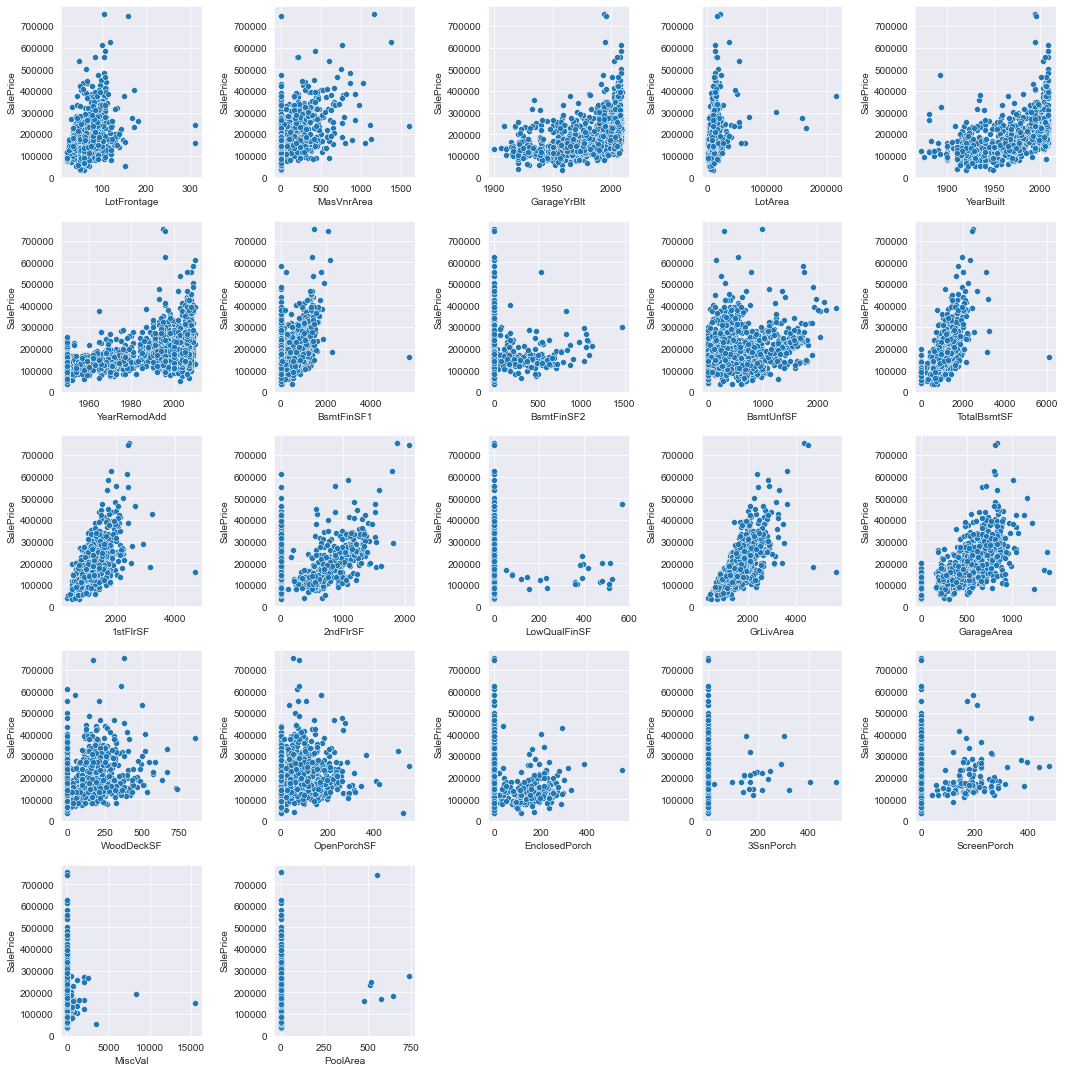

In [10]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))
for idx, col in enumerate(num_cols[:22]):
    _ = sns.scatterplot(data=train_data, x=col, y='SalePrice', ax=ax[idx//5, idx%5])
   #  _ = ax[idx//5, idx%5].set_title(col)
fig.tight_layout()
ax[4, 2].set_axis_off()
ax[4, 3].set_axis_off()
ax[4, 4].set_axis_off()


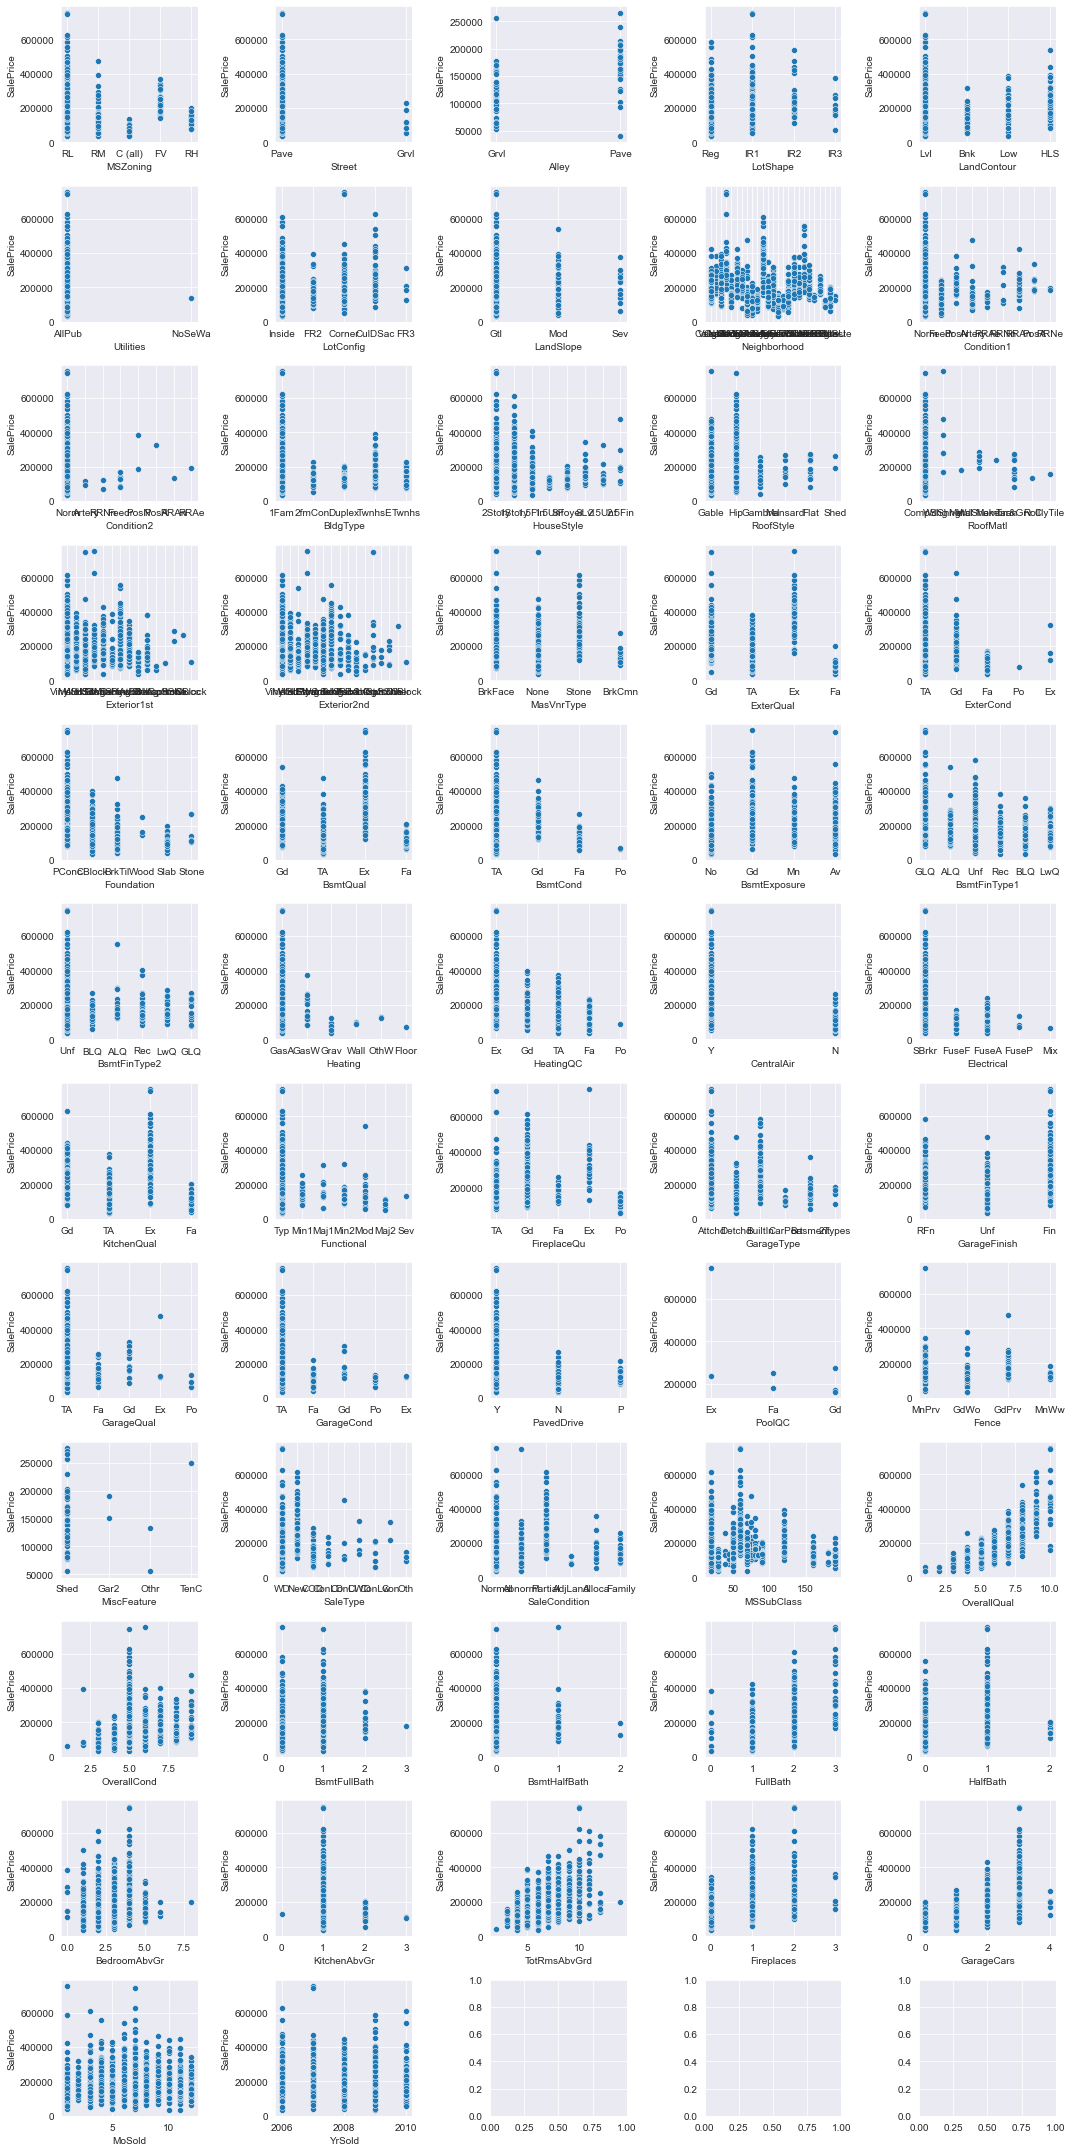

In [11]:
fig, ax = plt.subplots(12, 5, figsize=(15,30))
for idx, col in enumerate(cat_cols[:57]):
    _ = sns.scatterplot(data=train_data, x=col, y='SalePrice', ax=ax[idx//5, idx%5])
   # _ = ax[idx//5, idx%5].set_title(col)
fig.tight_layout()

### Outlier removal

In [12]:
## only drop samples from train set
train_set_cond = full_data['Id']<=len_train

index_to_drop = full_data[
    (full_data['SalePrice']<300000) & (full_data['GrLivArea']>4000) & train_set_cond
].index

LotFrontAge_idx = full_data[
    (full_data['SalePrice']<300000) & (full_data['LotFrontage']>300) & train_set_cond
].index

index_to_drop = index_to_drop.union(LotFrontAge_idx, )

BsmtSF1_idx = full_data[
    (full_data['SalePrice']<200000) & (full_data['BsmtFinSF1']>4000) & train_set_cond
].index
index_to_drop = index_to_drop.union(BsmtSF1_idx)

TotalBsmtSF_idx = full_data[
    (full_data['SalePrice']<200000) & (full_data['TotalBsmtSF']>6000) & train_set_cond
].index
index_to_drop = index_to_drop.union(TotalBsmtSF_idx)

LotArea_idx = full_data[
    full_data['LotArea']>100000
].index

index_to_drop = index_to_drop.union(LotArea_idx)



### Missing values

In [13]:
def percent_miss(df: pd.DataFrame):
    
    nan_df = df.isna().sum(axis=0).rename('nan_counts')
    nan_df = nan_df.divide(df.shape[0]).reset_index()
    nan_df.sort_values(by='nan_counts', ascending=False, inplace=True)
    return nan_df

nan_df = percent_miss(X_full)

<AxesSubplot:xlabel='index', ylabel='nan_counts'>

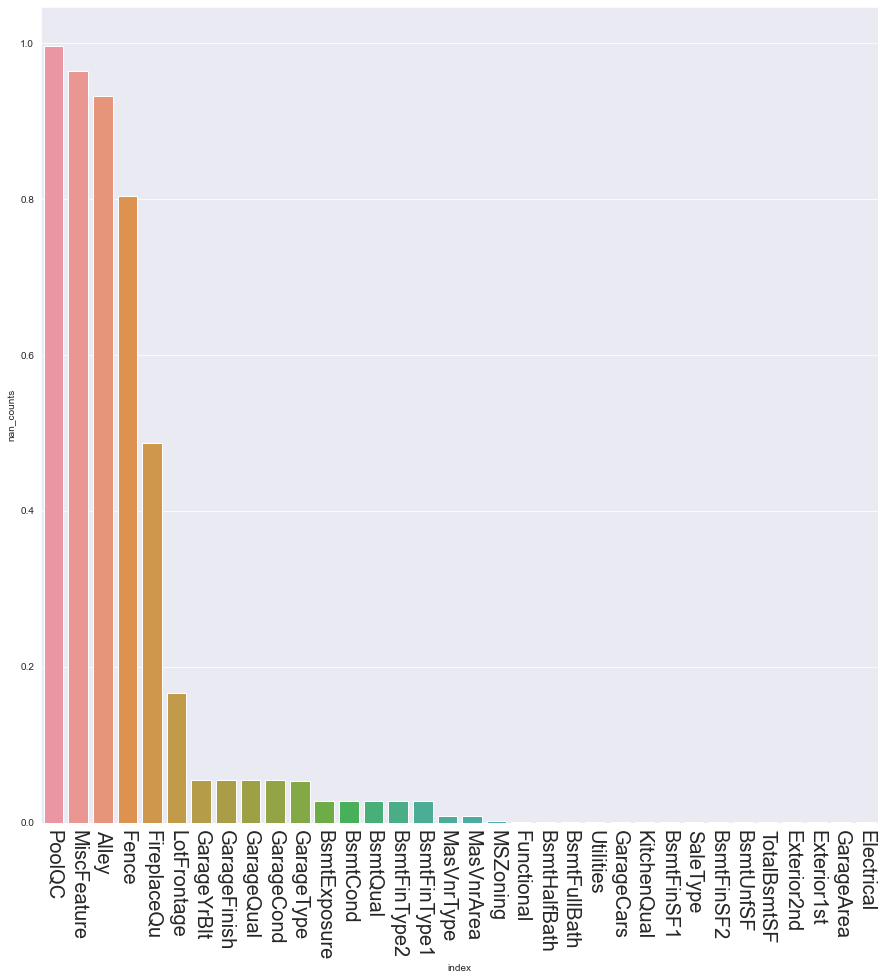

In [14]:
nan_df = nan_df.drop(nan_df[nan_df['index']=='SalePrice'].index)
nan_df = nan_df.drop(nan_df[nan_df['nan_counts']==0].index)
## visualize the missing data
fig, ax = plt.subplots(1,1,figsize=(15,15))
sns.barplot(ax=ax, data=nan_df, x='index', y='nan_counts')
ax.tick_params(axis='x', rotation=270, labelsize=20)

#### impute the missing values

As is described in the feature explaination file. For some columns, Nan means None. E.g. nan in PoolQC means no pool in this property.

In [15]:
# LotFrontage
from sklearn.impute import SimpleImputer

na_imputer = SimpleImputer(fill_value='None', strategy='constant')
zero_imputer = SimpleImputer(fill_value=0, strategy='constant')
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

na_columns = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType',
    'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2',
    'BsmtFinType1', 'MasVnrType'
]

zero_columns = [
    'GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 
    'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF', 
    'GarageArea'
]

median_columns = list(set(num_cols)-set(na_columns)-set(zero_columns))
mode_columns = list(set(cat_cols)-set(na_columns)-set(zero_columns))

imputers = ColumnTransformer(
    transformers = [
        ('na_', na_imputer, na_columns),
        ('zero_', zero_imputer, zero_columns),
        ('median_', median_imputer, median_columns),
        ('mode_', mode_imputer, mode_columns)
    ]
)
new_cols = []
tf_X = imputers.fit_transform(X_full)

for col in imputers.get_feature_names_out():
    new_cols.append(col[col.rfind('_')+1:])
    
X_full_tf = pd.DataFrame(tf_X, columns=new_cols)
X_full_tf['Id'] = X_full['Id']

# update origin dataframe
X_full = X_full_tf.copy()



### Feature construction

following features will be constructed and added into the dataset:

- eps = 0.1 : for avoiding divided by zero 

-- Area regarding to level

- 'TotalGrFlrSF' = '1stFlrSF' + '2ndFlrSF' : num,  Total above grade square feet
- 'TotalSF' = 'TotalGrFlrSF'+'TotalBsmtSF': num. Total square feet.

-- bedroom related

- 'BedroomAvgAbGr' = 'GrLivArea' / ('BedroomAbvGr' + eps) : num, average area per bedroom


-- bathroom related

- 'TotalBathAbGr' = 'FullBath'+'HalfBath'*0.5 : cat, total number of bathrooms above grade
- 'TotalBathBsmt' = 'BsmtFullBath'+ 'BsmtHalfBath'*0.5 : cat, total number of bathrooms in basement
- 'TotalBath' = 'TotalBathAbGr'+'TotalBathBsmt': cat, total number of bathrooms
- 'BedroomBathRatioAbGr' = 'BedroomAbvGr'/('TotalBathAbGr'+eps): num, ratio between bedrooms and bathrooms above ground
- 'BedroomBathRatio' = 'BedroomAbvGr'/('TotalBath'+eps): num, ratio between bedrooms and bathrooms

-- garage related

- 'GarageAvgCarSF' = 'GarageArea'/('GarageCars'+eps): num, average garage size per car

-- Porch related

- 'TotalPorchSF' = 'OpenPorchSF'+'EnclosedPorch'+'3SsnPorch'+'ScreenPorch': num, total area of porch

-- Binary feature (for the zero-inflated feature)
- 'has'


In [16]:
# for avoiding divided by zero 
eps = 1

# Area regarding to level
# ---------------------------------
# Total above grade square feet
X_full['TotalGrFlrSF']=X_full['1stFlrSF']+X_full['2ndFlrSF']
num_cols.append('TotalGrFlrSF')

# Total square feet.
X_full['TotalSF']=X_full['TotalGrFlrSF']+X_full['TotalBsmtSF']
num_cols.append('TotalSF')


# Bedroom related
# ----------------------------------
# average area per bedroom
X_full['BedroomAvgAbGr']=X_full['GrLivArea']/(X_full['BedroomAbvGr']+eps)
num_cols.append('BedroomAvgAbGr')

# Bathroom related
# -----------------------------------
# total number of bathrooms above grade

X_full['TotalBathAbGr']=X_full['FullBath']+X_full['HalfBath']*0.5
cat_num_cols.append('TotalBathAbGr')

# total number of bathrooms in basement
X_full['TotalBathBsmt']=X_full['BsmtFullBath']+X_full['BsmtHalfBath']*0.5
cat_num_cols.append('TotalBathBsmt')

# total number of bathrooms
X_full['TotalBath']=X_full['TotalBathAbGr']+X_full['TotalBathBsmt']
cat_num_cols.append('TotalBath')

# ratio between bedrooms and bathrooms above ground
X_full['BedroomBathRatioAbGr']=X_full['BedroomAbvGr']/(X_full['TotalBathAbGr']+eps)
num_cols.append('BedroomBathRatioAbGr')

# ratio between bedrooms and bathrooms

X_full['BedroomBathRatio']=X_full['BedroomAbvGr']/(X_full['TotalBath']+eps)
num_cols.append('BedroomBathRatio')

# garage related
# ----------------------
# average garage size per car

X_full['GarageAvgCarSF']=X_full['GarageArea']/(X_full['GarageCars']+eps)
num_cols.append('GarageAvgCarSF')

# Porch related
# ------------------
# total area of porch
X_full['TotalPorchSF']=X_full['OpenPorchSF']+X_full['EnclosedPorch']+X_full['3SsnPorch']+X_full['ScreenPorch']

num_cols.append('TotalPorchSF')




In [17]:
for col in num_cols:
    X_full[col] = X_full[col].astype('float64')
for col in cat_num_cols:
    X_full[col] = X_full[col].astype('int64')

Add additional features

- Overall State:
'OverallState' = 'OverallQual'+'OverallCond'

- Age: 
'Age' = 'YrSold'-'YearBuilt'

- RemodAge:
'RemodAge' = 'YrSold'-'YearRemodAdd'

- RemodStart:
'RemodStart' = 'YearRemodAdd'-'YearBuilt'

- GrAvgRoomSF:
'GrAvgRoomSF' = 'GrLivArea' / ('BedroomAbvGr'+'KitchenAbvGr'+'TotalBathAbGr'+eps)

- TotalBath:
'TotalBath' = 'TotalBathAbGr'+'TotalBathBsmt'*0.5

- HighQualSF:
'HighQualSF' = 'GrLivArea'+'1stFlrSF'+'2ndFlrSF'+0.5*'GarageArea'+0.5*'TotalBsmtSF'
               +'MasVnrArea'


In [48]:
# Overall state
X_full['OverallState']=X_full['OverallQual']+X_full['OverallCond']

# Age
X_full['Age']=X_full['YrSold']-X_full['YearBuilt']
X_full['Age'] = X_full['Age'].apply(
    lambda x: x if x>=0 else 0
)

# RemodAge:
X_full['RemodAge'] = X_full['YrSold']-X_full['YearRemodAdd']
X_full['RemodAge'] = X_full['RemodAge'].apply(
    lambda x: x if x>=0 else 0
)

# RemodStart:
X_full['RemodStart'] = X_full['YearRemodAdd']-X_full['YearBuilt']
X_full['RemodStart'] = X_full['RemodStart'].apply(
    lambda x: x if x>=0 else 0
)


# GrAvgRoomSF:
X_full['GrAvgRoomSF'] = X_full['GrLivArea']/(
    X_full['BedroomAbvGr']+X_full['KitchenAbvGr']+X_full['TotalBathAbGr']+eps
)

# TotalBath:
X_full['TotalBath'] = X_full['TotalBathAbGr']+X_full['TotalBathBsmt']*0.5

# HighQualSF:
X_full['HighQualSF'] = X_full['GrLivArea']+X_full['1stFlrSF']+X_full['2ndFlrSF']+\
0.5*X_full['GarageArea']+0.5*X_full['TotalBsmtSF']+X_full['MasVnrArea']

num_cols.extend(['OverallState', 'Age', 'RemodAge', 'RemodStart', 'GrAvgRoomSF',
                 'TotalBath', 'HighQualSF'
                ])





In [67]:
# identify zero-inflated feature
zero_inflated_cols = []
for col in num_cols:
    if np.sum(X_full[col]==0) >= 0.4*X_full.shape[0]:
        zero_inflated_cols.append(col)

# create binary features for those zero-inflated_cols
for col in zero_inflated_cols:
    X_full['has_'+col] = X_full[col].apply(lambda x: 0 if x==0 else 1)
    
zero_inflated_cols

['ScreenPorch',
 '3SsnPorch',
 'EnclosedPorch',
 'PoolArea',
 'LowQualFinSF',
 'OpenPorchSF',
 'BsmtFinSF2',
 '2ndFlrSF',
 'MiscVal',
 'MasVnrArea',
 'WoodDeckSF',
 'RemodStart']

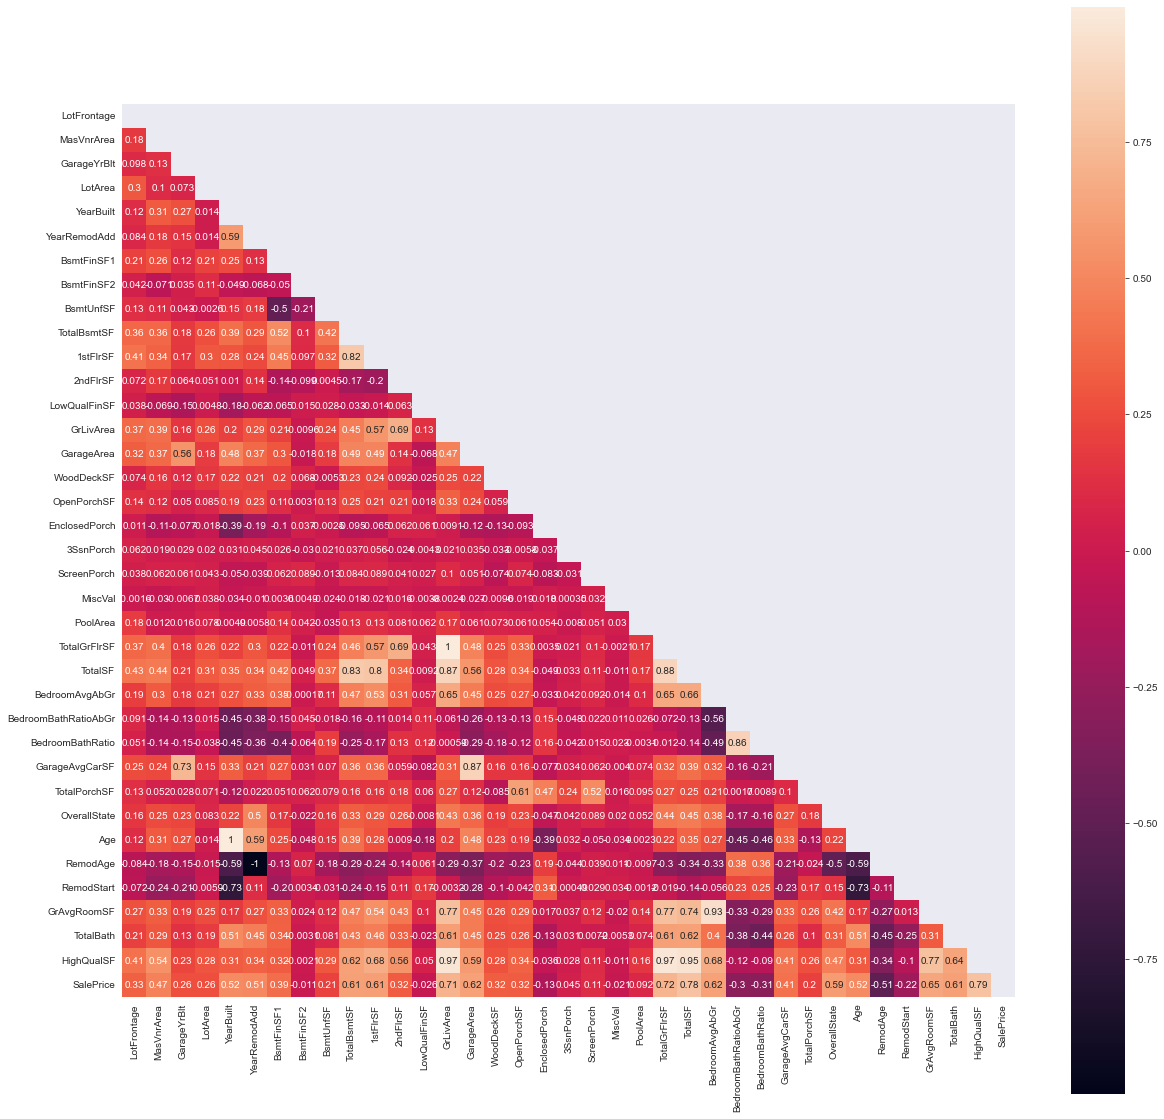

In [23]:
dummy = X_full[:len_train].copy()
dummy['SalePrice']=y_train['SalePrice']
corr = dummy[num_cols+['SalePrice']].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(1,1, figsize=(20, 20))
_ = sns.heatmap(corr, mask=mask, square=True, cmap=cmap, ax=ax, annot=True)

### Data transformation

#### Target: 'SalePrice'

Observation and Decisions:
- The data distribution is not normalized, it shall be transformed using box-cox transform


In [24]:
from scipy.stats import norm, skew
from scipy import stats

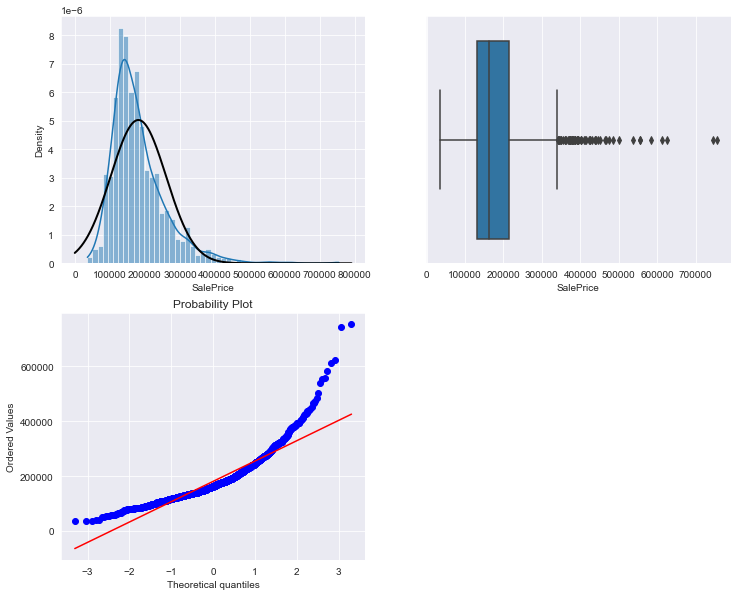

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
mu, std = norm.fit(y_train['SalePrice'])
_ = sns.histplot(data=y_train, x='SalePrice', kde=True, ax=ax[0, 0], stat='density')
_ =sns.boxplot(data=y_train, x='SalePrice', ax=ax[0, 1], orient='y')
x_min, x_max= ax[0, 0].get_xlim()
x = np.linspace(x_min, x_max, 1000)
p = norm.pdf(x, mu, std)
_ = ax[0, 0].plot(x, p, c='k', lw=2)

_= stats.probplot(y_train['SalePrice'], plot=ax[1, 0])
ax[1, 1].set_axis_off()

In [26]:
from sklearn.preprocessing import PowerTransformer
target_pt = PowerTransformer()
y_train['SalePrice_log'] = np.log1p(y_train['SalePrice'])
y_train['SalePrice_tf'] =  target_pt.fit_transform(y_train['SalePrice'].values.reshape(-1,1))

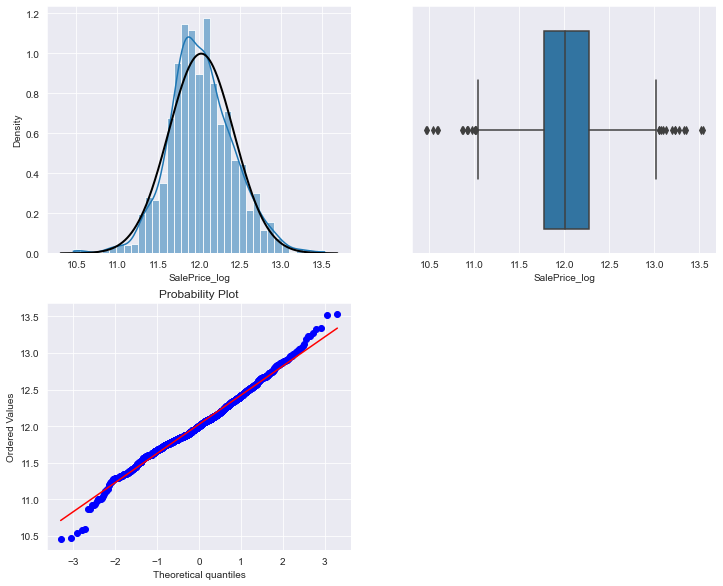

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
mu, std = norm.fit(y_train['SalePrice_log'])
_ = sns.histplot(data=y_train, x='SalePrice_log', kde=True, ax=ax[0, 0], stat='density')
_ = sns.boxplot(data=y_train, x='SalePrice_log', ax=ax[0, 1], orient='y')
x_min, x_max= ax[0, 0].get_xlim()
x = np.linspace(x_min, x_max, 1000)
p = norm.pdf(x, mu, std)
_ = ax[0, 0].plot(x, p, c='k', lw=2)

_ = stats.probplot(y_train['SalePrice_log'], plot=ax[1, 0])
ax[1, 1].set_axis_off()

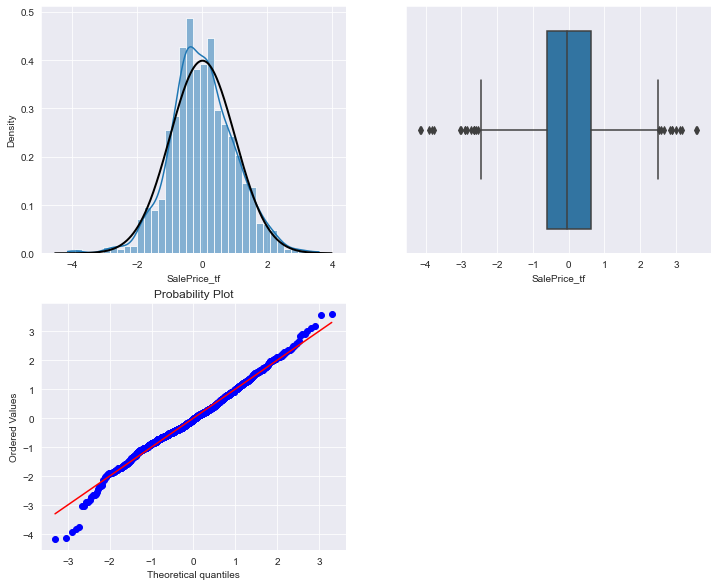

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
mu, std = norm.fit(y_train['SalePrice_tf'])
_ = sns.histplot(data=y_train, x='SalePrice_tf', kde=True, ax=ax[0, 0], stat='density')
_ = sns.boxplot(data=y_train, x='SalePrice_tf', ax=ax[0, 1], orient='y')
x_min, x_max= ax[0, 0].get_xlim()
x = np.linspace(x_min, x_max, 1000)
p = norm.pdf(x, mu, std)
_ = ax[0, 0].plot(x, p, c='k', lw=2)

_ = stats.probplot(y_train['SalePrice_tf'], plot=ax[1, 0])
ax[1, 1].set_axis_off()

#### Transform other numerical features

#####  Explore the distribution of numerical features

Observations and decisions:

- some of features have too many zeros, maybe it is not a good idea to do the box-cox transform on them directly, insteadly it can be constructed a binary feature for them and divided them into two groups

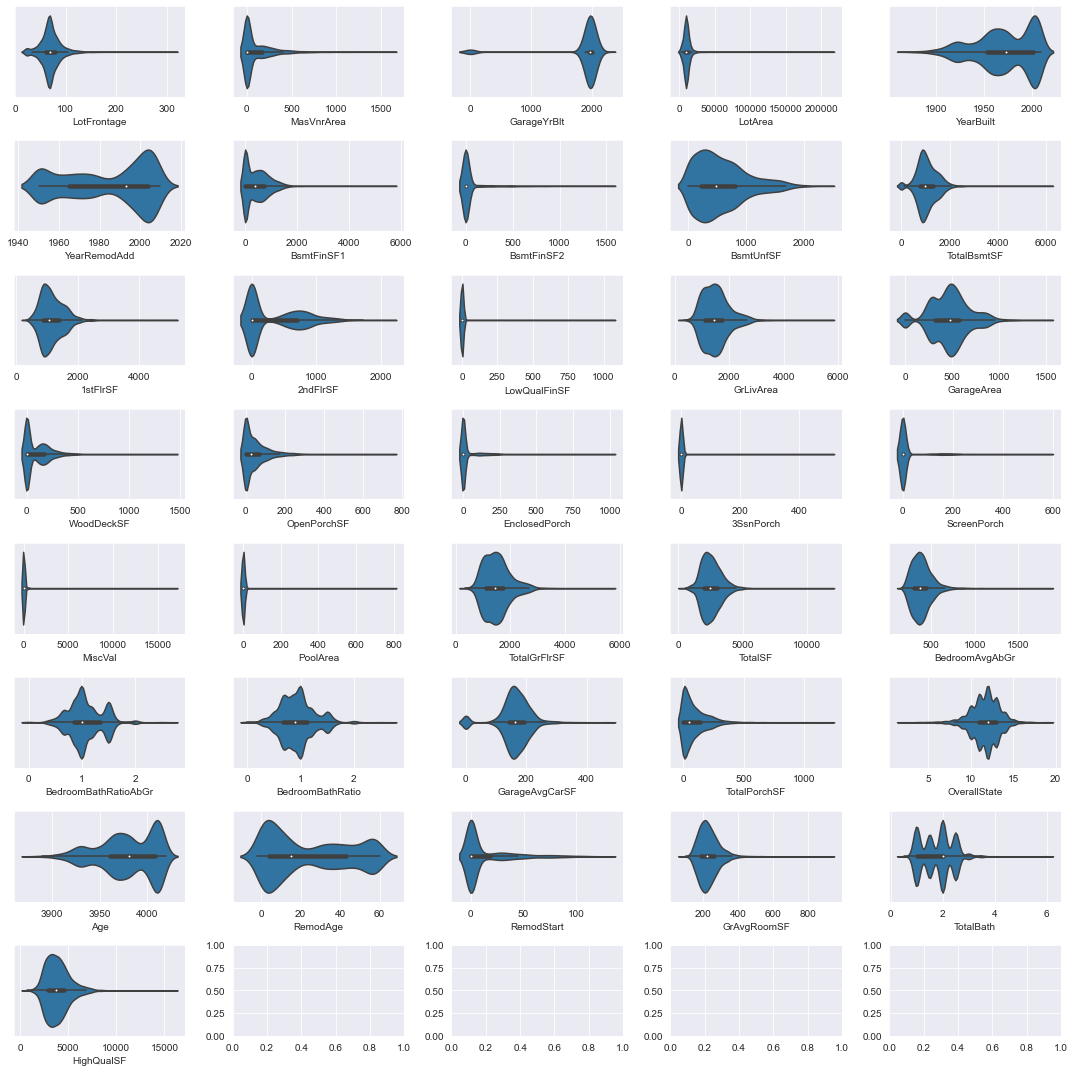

In [31]:
fig, ax = plt.subplots(8, 5, figsize=(15,15))
for idx, col in enumerate(num_cols):
    _ = sns.violinplot(data=X_full, x=col, ax=ax[idx//5, idx%5])

fig.tight_layout()

##### Perform the box-cox transformation

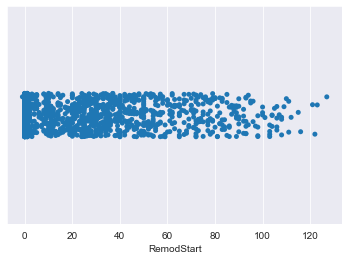

In [45]:
_=sns.stripplot(data=X_full, x='RemodStart')

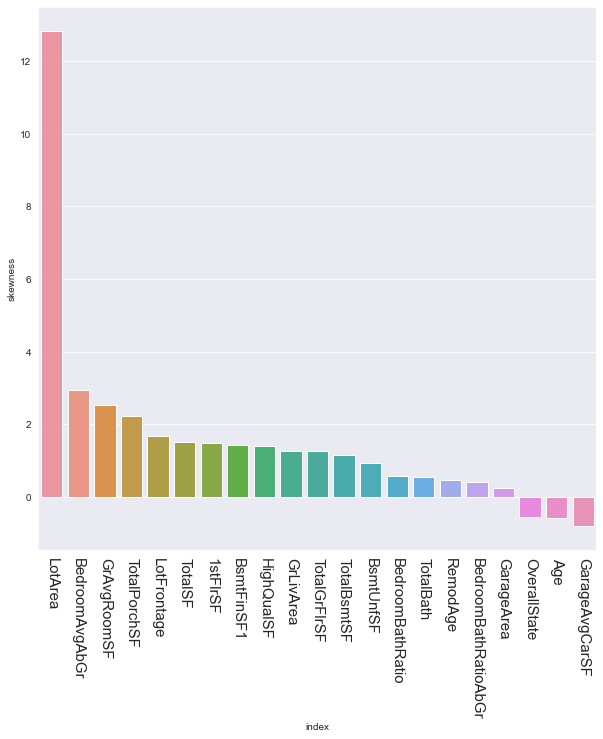

In [68]:
check_skewness_cols = num_cols.copy()
check_skewness_cols.remove('YearBuilt')
check_skewness_cols.remove('GarageYrBlt')
check_skewness_cols.remove('YearRemodAdd')
for col in zero_inflated_cols:
    check_skewness_cols.remove(col)

skewness = (X_full[check_skewness_cols].apply(lambda x: skew(x.dropna()))
            .sort_values(ascending=False))

skew_df = pd.DataFrame({'skewness' :skewness}).reset_index()

fig, ax = plt.subplots(1,1,figsize=(10,10))
g = sns.barplot(data=skew_df, x='index', y='skewness', ax=ax)
ax.tick_params(axis='x', rotation=270, labelsize=15)


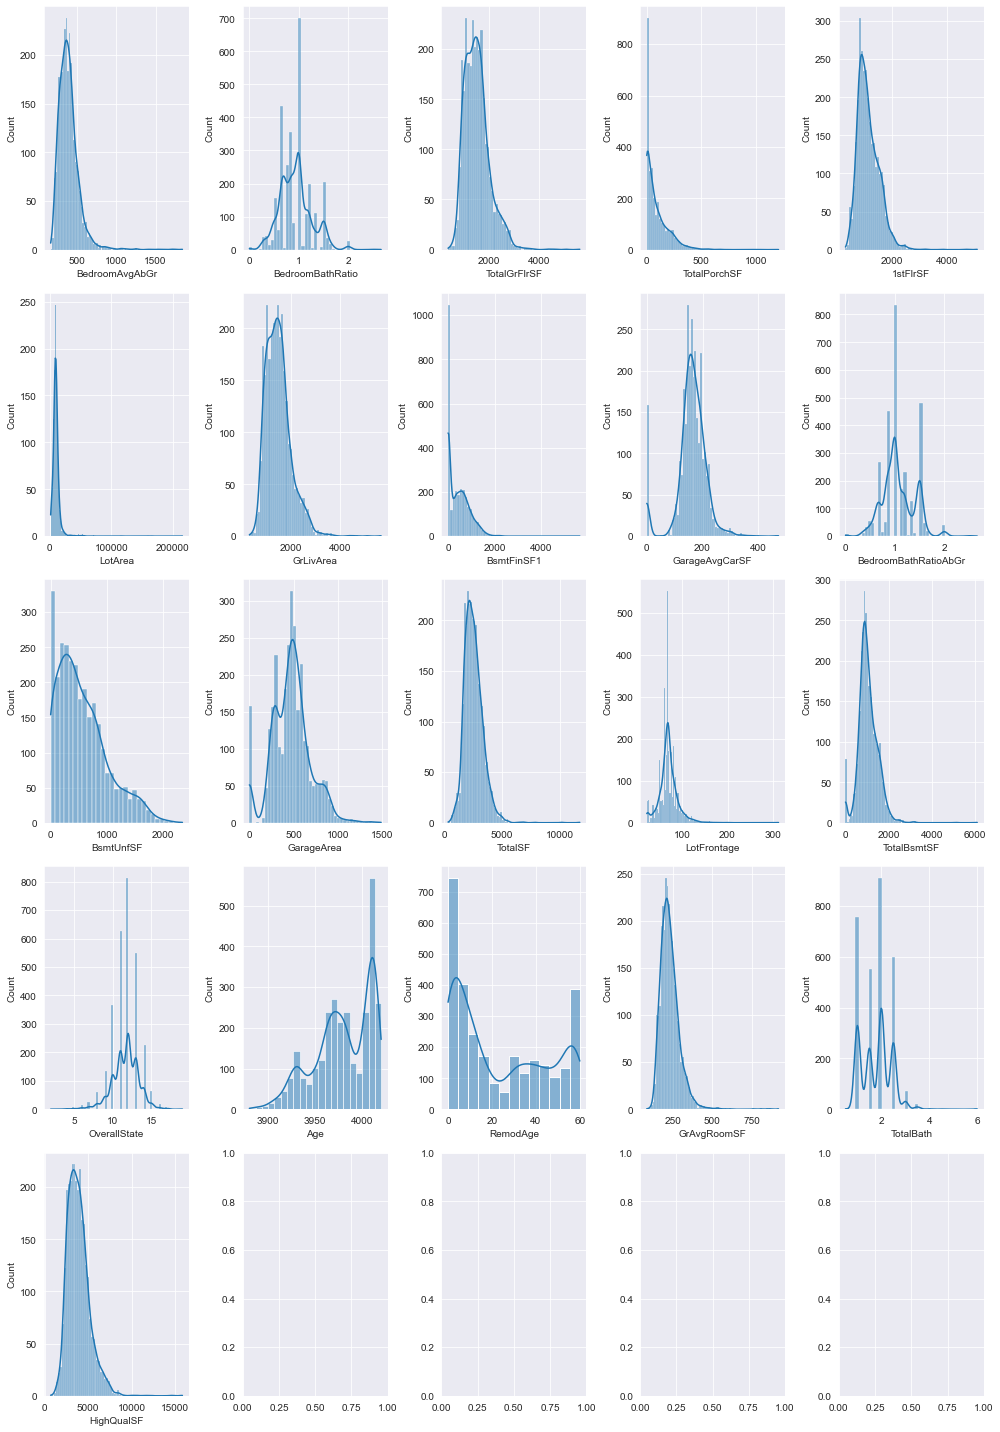

In [69]:
fig, ax = plt.subplots(5, 5, figsize=(14, 20))

for idx, col in enumerate(check_skewness_cols):
    _ = sns.histplot(data=X_full, x=col, kde=True, 
                     ax=ax[idx//5, idx%5])
    
fig.tight_layout()
    

In [70]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

tf_skew_df = skew_df[abs(skew_df['skewness']>0.7)]
# for col in tf_skew_df['index']:
#     # print(col)
#     not_nan_idx = ~X_full[col].isna()
#     col_data = X_full.loc[not_nan_idx, [col]].values[:, 0]
#     X_full_test.loc[not_nan_idx, [col]] = boxcox1p(col_data, 0.125)

pt = PowerTransformer(method='box-cox')

tf_cols = [i + '_boxcox_tf' for i in tf_skew_df['index'].values]
X_full[tf_cols] = pt.fit_transform(
    X_full[tf_skew_df['index']]+1
)


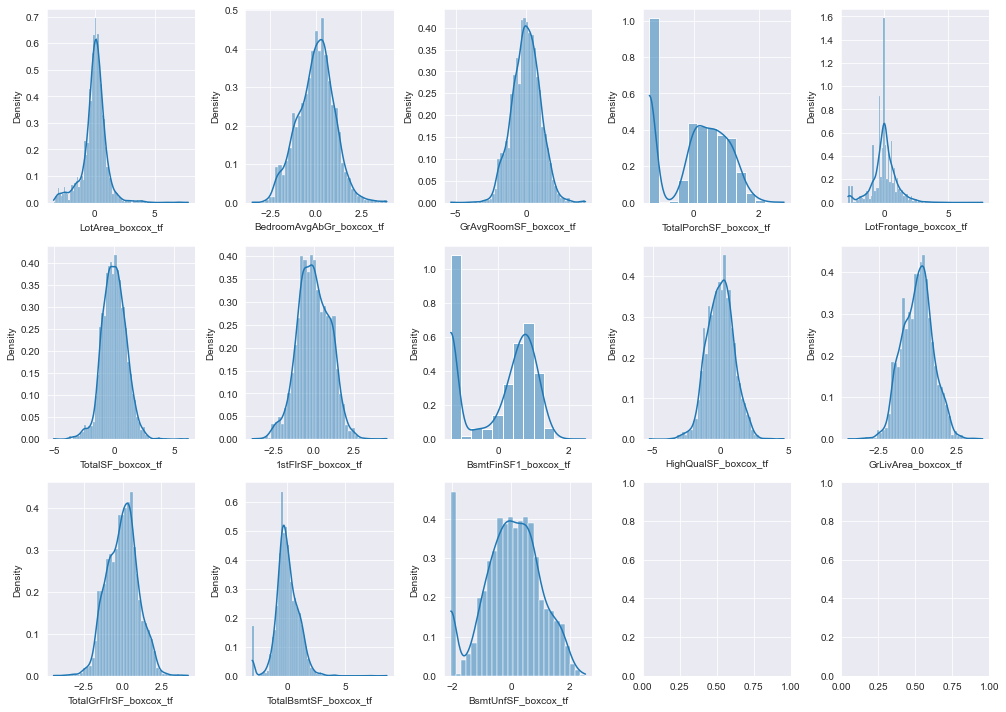

In [71]:
fig, ax = plt.subplots(3, 5, figsize=(14, 10))

for idx, col in enumerate(tf_cols):
    _ = sns.histplot(data=X_full, x=col, kde=True, 
                     stat='density', ax=ax[idx//5, idx%5])
    
fig.tight_layout()

#### category encoding

In [56]:
cols_to_encode, encoded_cols = [], []
for col in X_full.columns:
    if X_full[col].dtype == 'object':
        cols_to_encode.append(col)
        encoded_cols.append(col+'_encoded')
skew_cols = tf_skew_df['index'].to_list()
base_cols = X_full.columns[
    (~X_full.columns.str.contains('encoded')) & (~X_full.columns.str.contains('boxcox')) & 
    (~X_full.columns.str.startswith('Id'))
]

In [58]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='error')
X_full[encoded_cols] = encoder.fit_transform(X_full[cols_to_encode])

## ML model

- Random forest will be used as a baseline

In [59]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
random_seed = 42

    

/Users/johnlin/opt/anaconda3/envs/ds_py37/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [60]:
class PlusOne(BaseEstimator, TransformerMixin):
    
    def __init__(self,):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X+1
    
    def get_feature_names_out(self, input_features=None):
        return input_features

pt_pipe = Pipeline(
    steps=[
        ('p1', PlusOne()),
        ('pt', PowerTransformer(method='box-cox'))
    ]
)
    
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def rmsle_cv(model, X, y, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [80]:
## Initiate base models:

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.005, l1_ratio=.9, random_state=3))
KRR = KernelRidge()
GBoost = GradientBoostingRegressor()
model_xgb = xgb.XGBRegressor()
rf_reg = RandomForestRegressor()

models_dict = {
    'lasso': lasso,
    'ENet': ENet,
    'KRR': KRR,
    'GBoost': GBoost,
    'model_xgb': model_xgb,
    'rf_reg': rf_reg
}

# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
# 
# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
# 
# KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# 
# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)
# 
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, random_state =7, nthread = -1)
# 
# rf_reg = RandomForestRegressor(n_estimators=2200)




### Comparison

#### Baseline 

default RFregressor -- RF score: 0.1421 (0.0074)

In [81]:
pipe = ColumnTransformer(
    transformers=[
        ('power_trans', pt_pipe, skew_cols),
        ('ordinal_encode', OrdinalEncoder(handle_unknown='error'), cols_to_encode),
    ], remainder= 'passthrough'
)

df = X_full[base_cols].copy()

X = pipe.fit_transform(df)
X_train, X_test = X[:len_train], X[len_train:]
y = y_train['SalePrice_log']

for key, model in models_dict.items():
    score = rmsle_cv(model, X=X_train, y=y)
    print("\n {}_score: {:.4f} ({:.4f})\n".format(key, score.mean(), score.std())) 


 lasso_score: 0.1358 (0.0161)


 ENet_score: 0.1355 (0.0161)


 KRR_score: 0.1380 (0.0201)


 GBoost_score: 0.1274 (0.0097)


 model_xgb_score: 0.1426 (0.0091)


 rf_reg_score: 0.1396 (0.0087)



#### What if add binary feature for those zero inflated features

In [82]:
drop_cols = ['has_MiscVal', 'MiscVal']

pipe = ColumnTransformer(
    transformers=[
        ('power_trans', pt_pipe, list(set(skew_cols)-set(drop_cols))),
        ('ordinal_encode', OrdinalEncoder(handle_unknown='error'), cols_to_encode),
    ], remainder= 'passthrough'
)

binary_cols = X_full.columns[X_full.columns.str.contains('has_')]
df = X_full[list((set(base_cols)-set(drop_cols)) | set(binary_cols))].copy()

X = pipe.fit_transform(df)
X_train, X_test = X[:len_train], X[len_train:]
y = y_train['SalePrice_log']

for key, model in models_dict.items():
    score = rmsle_cv(model, X=X_train, y=y)
    print("\n {}_score: {:.4f} ({:.4f})\n".format(key, score.mean(), score.std())) 



 lasso_score: 0.1353 (0.0158)


 ENet_score: 0.1350 (0.0158)


 KRR_score: 0.1377 (0.0203)


 GBoost_score: 0.1281 (0.0095)


 model_xgb_score: 0.1408 (0.0080)


 rf_reg_score: 0.1409 (0.0089)



#### What if transform zero-inflated features into binary feature

In [83]:
binary_cols

Index(['has_MasVnrArea', 'has_BsmtFinSF2', 'has_2ndFlrSF', 'has_LowQualFinSF',
       'has_WoodDeckSF', 'has_OpenPorchSF', 'has_EnclosedPorch',
       'has_3SsnPorch', 'has_ScreenPorch', 'has_MiscVal', 'has_PoolArea',
       'has_RemodStart'],
      dtype='object')

In [84]:
drop_cols = ['has_MiscVal', 'MiscVal']

pipe = ColumnTransformer(
    transformers=[
        ('power_trans', pt_pipe, 
         list(set(skew_cols)-set(drop_cols)-set(zero_inflated_cols))),
        ('ordinal_encode', OrdinalEncoder(handle_unknown='error'), cols_to_encode),
    ], remainder= 'passthrough'
)

binary_cols = X_full.columns[X_full.columns.str.contains('has_')]
df = X_full[list((set(base_cols)-set(drop_cols)-set(zero_inflated_cols)) | (set(binary_cols)-set(drop_cols)))].copy()

X = pipe.fit_transform(df)
X_train, X_test = X[:len_train], X[len_train:]
y = y_train['SalePrice_log']

for key, model in models_dict.items():
    score = rmsle_cv(model, X=X_train, y=y)
    print("\n {}_score: {:.4f} ({:.4f})\n".format(key, score.mean(), score.std())) 


 lasso_score: 0.1363 (0.0159)


 ENet_score: 0.1361 (0.0159)


 KRR_score: 0.1369 (0.0193)


 GBoost_score: 0.1260 (0.0090)


 model_xgb_score: 0.1400 (0.0068)


 rf_reg_score: 0.1395 (0.0096)



#### what if drop the outliers

In [85]:
drop_cols = ['has_MiscVal', 'MiscVal']

pipe = ColumnTransformer(
    transformers=[
        ('power_trans', pt_pipe, 
         list(set(skew_cols)-set(drop_cols)-set(zero_inflated_cols))),
        ('ordinal_encode', OrdinalEncoder(handle_unknown='error'), cols_to_encode),
    ], remainder= 'passthrough'
)

binary_cols = X_full.columns[X_full.columns.str.contains('has_')]
df = X_full[list((set(base_cols)-set(drop_cols)-set(zero_inflated_cols)) | 
                 (set(binary_cols)-set(drop_cols))
                )].copy()
df = df.drop(index=index_to_drop)

X = pipe.fit_transform(df)
len_train_new = len_train-(len(index_to_drop))
X_train, X_test = X[:len_train_new], X[len_train_new:]
y = y_train['SalePrice_log'].drop(index=index_to_drop)

for key, model in models_dict.items():
    score = rmsle_cv(model, X=X_train, y=y)
    print("\n {}_score: {:.4f} ({:.4f})\n".format(key, score.mean(), score.std())) 


 lasso_score: 0.1221 (0.0066)


 ENet_score: 0.1218 (0.0066)


 KRR_score: 0.1198 (0.0057)


 GBoost_score: 0.1203 (0.0067)


 model_xgb_score: 0.1382 (0.0046)


 rf_reg_score: 0.1352 (0.0068)



In [86]:
pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('power_trans',
                                 Pipeline(steps=[('p1', PlusOne()),
                                                 ('pt',
                                                  PowerTransformer(method='box-cox'))]),
                                 ['BedroomAvgAbGr', 'TotalSF', 'TotalGrFlrSF',
                                  'TotalBsmtSF', 'LotFrontage', 'TotalPorchSF',
                                  'GrLivArea', 'HighQualSF', 'GrAvgRoomSF',
                                  '1stFlrSF', 'BsmtFinSF1', 'LotArea',
                                  'BsmtUnfSF']),
                                ('ordinal_encode', OrdinalEnco...
                                 ['PoolQC', 'MiscFeature', 'Alley', 'Fence',
                                  'FireplaceQu', 'GarageQual', 'GarageFinish',
                                  'GarageCond', 'GarageType', 'BsmtCond',
                                  'BsmtExposure', 'BsmtQual', 'BsmtFinType2',
                                  'BsmtFinType1', 'MasVnrType', 'Exterior2nd',
                                  'Condition2', 'Foundation', 'SaleCondition',
                                  'LotShape', 'CentralAir', 'HouseStyle',
                                  'Exterior1st', 'Heating', 'Functional',
                                  'RoofMatl', 'Utilities', 'Neighborhood',
                                  'BldgType', 'Electrical', ...])])

### Add hyperparameter optimized model

In [89]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.005, l1_ratio=.9, random_state=3))

KRR = KernelRidge()

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
models_dict = {
    'lasso': lasso,
    'ENet': ENet,
    'KRR': KRR,
    'GBoost': GBoost,
    'model_xgb': model_xgb,
}


In [90]:
drop_cols = ['has_MiscVal', 'MiscVal']

pipe = ColumnTransformer(
    transformers=[
        ('power_trans', pt_pipe, 
         list(set(skew_cols)-set(drop_cols)-set(zero_inflated_cols))),
        ('ordinal_encode', OrdinalEncoder(handle_unknown='error'), cols_to_encode),
    ], remainder= 'passthrough'
)

binary_cols = X_full.columns[X_full.columns.str.contains('has_')]
df = X_full[list((set(base_cols)-set(drop_cols)-set(zero_inflated_cols)) | 
                 (set(binary_cols)-set(drop_cols))
                )].copy()
df = df.drop(index=index_to_drop)

X = pipe.fit_transform(df)
len_train_new = len_train-(len(index_to_drop))
X_train, X_test = X[:len_train_new], X[len_train_new:]
y = y_train['SalePrice_log'].drop(index=index_to_drop)

for key, model in models_dict.items():
    score = rmsle_cv(model, X=X_train, y=y)
    print("\n {}_score: {:.4f} ({:.4f})\n".format(key, score.mean(), score.std())) 


 lasso_score: 0.1221 (0.0066)


 ENet_score: 0.1218 (0.0066)


 KRR_score: 0.1198 (0.0057)


 GBoost_score: 0.1181 (0.0076)


 model_xgb_score: 0.1173 (0.0045)



In [91]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [92]:
averaged_models = AveragingModels(models = (ENet, GBoost, lasso, KRR))

score = rmsle_cv(averaged_models, X=X_train, y=y)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1152 (0.0065)



In [93]:
averaged_models.fit(X_train, y)
averaged_pred = np.expm1(averaged_models.predict(X_test))
model_xgb.fit(X_train, y)
model_xgb_pred = np.expm1(model_xgb.predict(X_test))

AveragingModels(models=(Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.005, l1_ratio=0.9,
                                                    random_state=3))]),
                        GradientBoostingRegressor(learning_rate=0.05,
                                                  loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  n_estimators=3000,
                                                  random_state=5),
                        Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('lasso',
                                         Lasso(alpha=0.005, random_state=1))]),
                        KernelRidge()))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603,
             enable_categorical=False, gamma=0.0468, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=4, nthread=-1, num_parallel_tree=1,
             predictor='auto', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
weighted_average = 0.6*averaged_pred + 0.4*model_xgb_pred 

In [95]:
sub_df = pd.DataFrame()
sub_df['Id'] = test_data['Id']
sub_df['SalePrice'] = weighted_average
sub_df.to_csv('submission.csv',index=False)

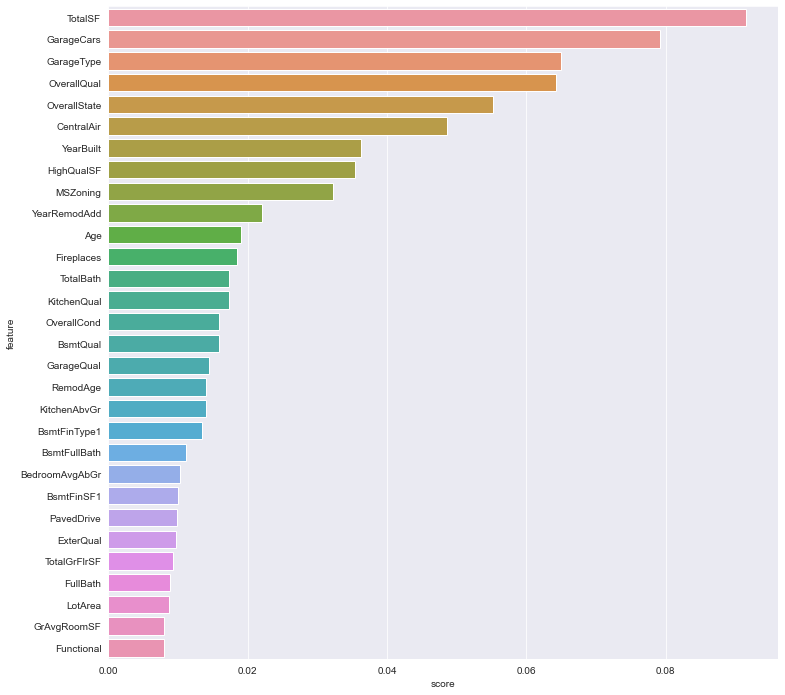

In [109]:
vip_df = pd.DataFrame()
vip_cols = []
for col in pipe.get_feature_names_out():
    vip_cols.append(col[col.rfind('_')+1:])

vip_df['feature'] = vip_cols
vip_df['score'] = model_xgb.feature_importances_

vip_df.sort_values(by='score', ascending=False, inplace=True)

fig, ax = plt.subplots(1,1, figsize=(12,12))
_=sns.barplot(data=vip_df.iloc[:30, :], x='score', y='feature', ax=ax, orient='h')

In [101]:
len(pipe.get_feature_names_out())

94